# Calibration, data analysis

In [1]:
#Import classic modules
# import numpy as np
# import matplotlib.pyplot as plt
import time

import datetime
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from scipy.spatial.transform import Rotation as rot

import matplotlib.animation as animation

%matplotlib inline
#%matplotlib notebook

## Parameters initialization

In [2]:
w_p = 5e9
w_if = 30e6
#Pow = 5
#phase = 0
#Period = 1e-3
N_Pulse = 100000

In [3]:
t_init = 0
t_final = 1e-6
T = t_final-t_init
n = int(np.ceil((T)/8e-9))#Point per pulsed length
pulse_length = n*8e-9

pulse_time = np.linspace(0,pulse_length,n)

time = np.linspace(0,pulse_length*N_Pulse,n*N_Pulse)
T_final = time[-1]
n

125

In [4]:
var = 0.5
mean = 0#0.01

signal = np.random.normal(mean, np.sqrt(var), n*N_Pulse)

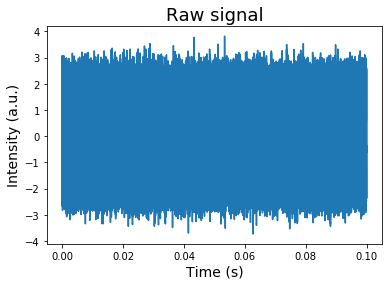

In [5]:
plt.plot(time,signal)
plt.xlabel('Time (s)',size=14)
plt.ylabel('Intensity (a.u.)',size=14)
plt.title('Raw signal',size=18)
plt.savefig('FullSignal.png',dpi = 200)
plt.show()

## Data analysis

### What happens for one pulse ?

In [6]:
pulse_pos = 1
single_pulse = signal[pulse_pos*n:(pulse_pos+1)*n]

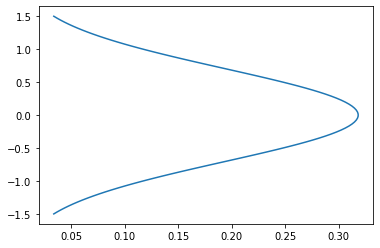

In [7]:
x = np.linspace(-1.5,1.5,100)
def GaussianDist(var,mu,x):
    std = np.sqrt(var)
    return (1/(2*np.pi*std**2))*np.exp(-(((x-mu)**2)/(2*std**2)))

plt.plot(GaussianDist(var,mean,x),x)
    

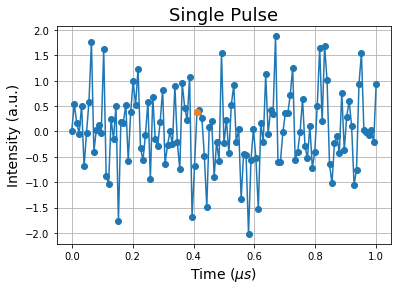

In [8]:
plt.title('Single Pulse',size=18)
plt.plot(pulse_time*1e6,single_pulse,marker = 'o')
plt.plot(pulse_time[51]*1e6,single_pulse[51],marker = 'o')
plt.xlabel(r'Time ($\mu{s}$)',size=14)
plt.ylabel('Intensity (a.u.)',size=14)
plt.savefig('SinglePulse.png',dpi = 200)
plt.grid()
plt.show()

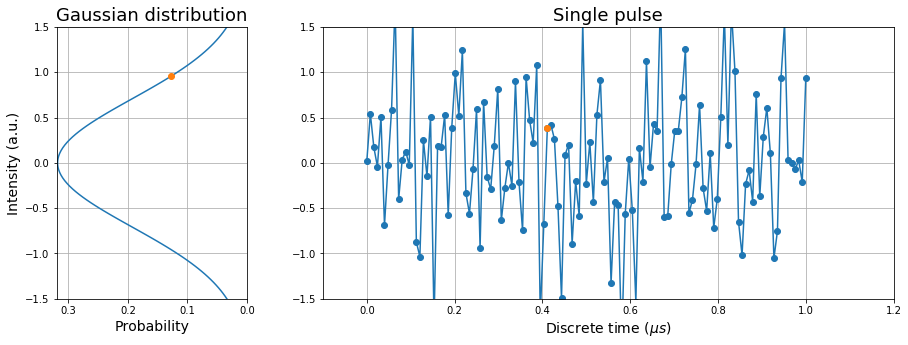

In [9]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 

#fig.suptitle(r'Single Pulse demodulated',size=18)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(GaussianDist(var,mean,x),x)
ax1.plot(GaussianDist(var,mean,x)[81],x[81],marker = 'o')
ax1.set_xlabel('Probability',size=14)
ax1.set_ylabel('Intensity (a.u.)',size=14)
ax1.set_title(r'Gaussian distribution',size=18)
ax1.set_xlim(0.32,0)
ax1.set_ylim(-1.5,1.5)
ax1.grid()

ax2.plot(pulse_time*1e6,single_pulse,marker = 'o')
ax2.plot(pulse_time[51]*1e6,single_pulse[51],marker = 'o')
ax2.set_xlabel(r'Discrete time $(\mu{s})$',size=14)
#ax2.set_ylabel('Intensity (a.u.)',size=14)
ax2.set_title(r'Single pulse',size=18)
ax2.set_ylim(-1.5,1.5)
ax2.set_xlim(-0.1,1.2)
ax2.grid()

plt.savefig('SingPulseGauss.png',dpi=200)
plt.show()

In [10]:
single_pulse[51]

0.3830544409755207

In [11]:
x[81]

0.9545454545454546

The first step is to demodulate this noisy signal.

In [12]:
d_w = 10e6

#Cp stand for positive cosine, Sp positive sine, Cm negative cosine and Sm negative sine
Cp = np.cos((w_if+d_w)*pulse_time)
Sp = np.sin((w_if+d_w)*pulse_time)
Cm = np.cos((w_if-d_w)*pulse_time)
Sm = np.sin((w_if-d_w)*pulse_time)

Qp = single_pulse * Cp
Ip = single_pulse * Sp
Qm = single_pulse * Cm
Im = single_pulse * Sm

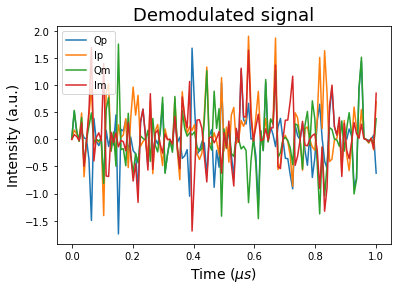

In [13]:
plt.title('Demodulated signal',size=18)
plt.plot(pulse_time*1e6,Qp,label='Qp')
plt.plot(pulse_time*1e6,Ip,label='Ip')
plt.plot(pulse_time*1e6,Qm,label='Qm')
plt.plot(pulse_time*1e6,Im,label='Im')
plt.legend()
plt.xlabel(r'Time ($\mu{s}$)',size=14)
plt.ylabel('Intensity (a.u.)',size=14)
plt.savefig('DemodSinglePulse_dw10.png',dpi=200)
plt.show()

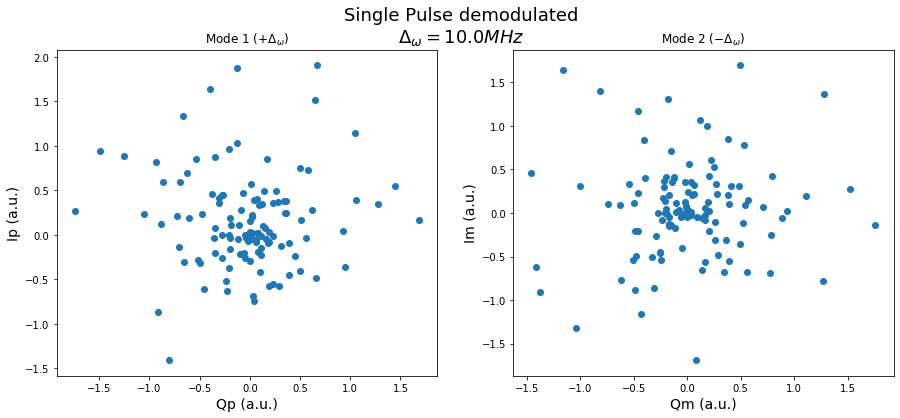

In [14]:
fig = plt.figure(figsize=(15,6))

d_wn = d_w*1e-6
fig.suptitle(r'Single Pulse demodulated''\n'r'$\Delta_\omega=%s MHz$' %d_wn,size=18)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(Qp,Ip)
ax1.set_xlabel('Qp (a.u.)',size=14)
ax1.set_ylabel('Ip (a.u.)',size=14)
ax1.set_title(r'Mode 1 ($+\Delta_\omega$)')

ax2.scatter(Qm,Im)
ax2.set_xlabel('Qm (a.u.)',size=14)
ax2.set_ylabel('Im (a.u.)',size=14)
ax2.set_title(r'Mode 2 ($-\Delta_\omega$)')
plt.savefig('DemodSinglePulseScat_dw10.png',dpi=200)
plt.show()

In [15]:
#Now we average this pulse
Qpan = np.average(Qp)
Ipan = np.average(Ip)
Qman = np.average(Qm)
Iman = np.average(Im)

Qpat = (1/pulse_length)*sum(Qp)
Ipat = (1/pulse_length)*sum(Ip)
Qmat = (1/pulse_length)*sum(Qm)
Imat = (1/pulse_length)*sum(Im)

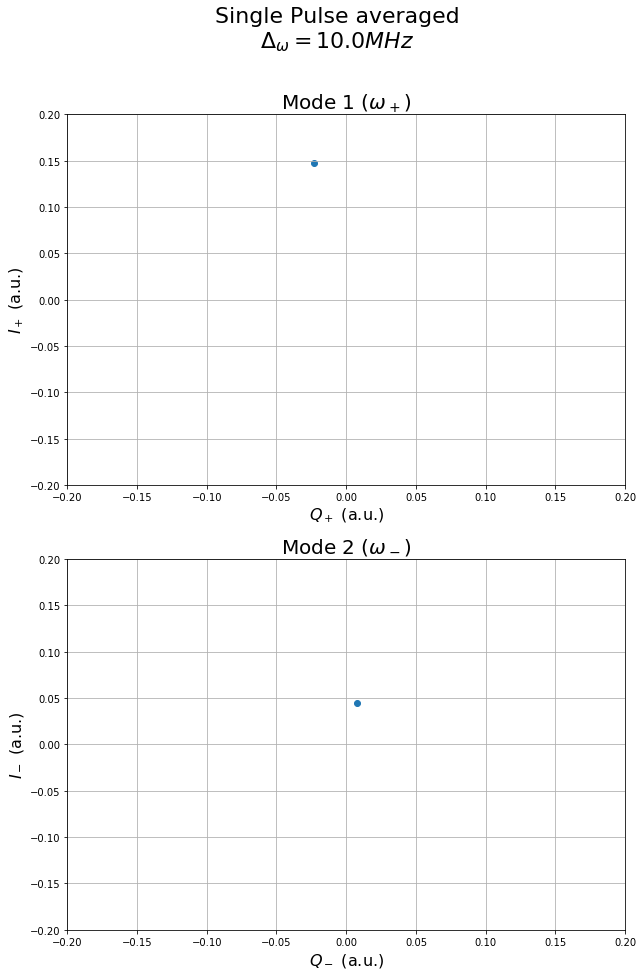

In [16]:
fig = plt.figure(figsize=(10,15))

d_wn = d_w*1e-6
fig.suptitle(r'Single Pulse averaged''\n'r'$\Delta_\omega=%s MHz$' %d_wn,size=22)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(Qpan,Ipan)
ax1.set_xlabel(r'$Q_+$ (a.u.)',size=16)
ax1.set_ylabel(r'$I_+$ (a.u.)',size=16)
ax1.set_title(r'Mode 1 ($\omega_+$)',size=20)
ax1.set_xlim(-0.2,0.2)
ax1.set_ylim(-0.2,0.2)
ax1.grid()

ax2.scatter(Qman,Iman)
ax2.set_xlabel(r'$Q_-$ (a.u.)',size=16)
ax2.set_ylabel(r'$I_-$ (a.u.)',size=16)
ax2.set_title(r'Mode 2 ($\omega_-$)',size=20)
ax2.set_xlim(-0.2,0.2)
ax2.set_ylim(-0.2,0.2)
ax2.grid()
plt.savefig('AveDemodSinglePulse_dw10.png', dpi = 200)
plt.show()

Let's now repeat this step over the whole signal

In [17]:
def IQpm(signal,d_w,pulse_time):
    #Cp stand for positive cosine, Sp positive sine, Cm negative cosine and Sm negative sine
    Cp = np.cos((w_if+d_w)*pulse_time)
    Sp = np.sin((w_if+d_w)*pulse_time)
    Cm = np.cos((w_if-d_w)*pulse_time)
    Sm = np.sin((w_if-d_w)*pulse_time)
    
    #The 's' index here means, sequenced.
    Qps = []
    Ips = []
    Qms = []
    Ims = []
    n = len(pulse_time)
    for k in range(N_Pulse):
        Qps.append(signal[int((k*n)):int((k+1)*n)]*Cp)
        Ips.append(signal[int((k*n)):int(((k+1)*n))]*Sp)
        Qms.append(signal[int((k*n)):int(((k+1)*n))]*Cm)
        Ims.append(signal[int((k*n)):int(((k+1)*n))]*Sm)
        #The 'a' index here means, averaged.
    Qpa = []
    Ipa = []
    Qma = []
    Ima = []

    for k in range(N_Pulse):
        Qpa.append(np.average(Qps[k]))
        Ipa.append(np.average(Ips[k]))
        Qma.append(np.average(Qms[k]))
        Ima.append(np.average(Ims[k]))
    Qpa = np.asarray(Qpa)
    Ipa = np.asarray(Ipa)
    Qma = np.asarray(Qma)
    Ima = np.asarray(Ima)
    return Qpa, Ipa, Qma, Ima

In [18]:
len(pulse_time)

125

In [19]:
IQ = IQpm(signal,d_w,pulse_time)
Qpa_tot = IQ[0]
Ipa_tot = IQ[1]
Qma_tot = IQ[2]
Ima_tot = IQ[3]

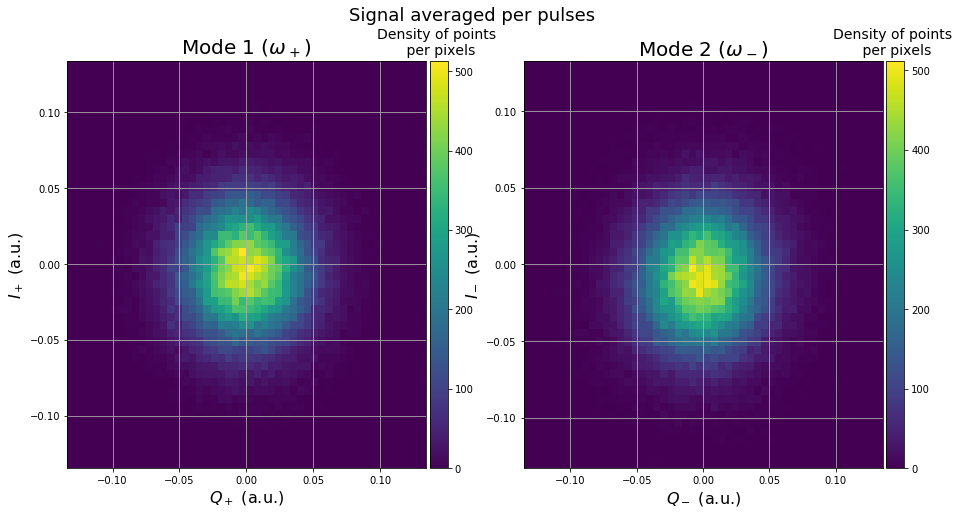

In [20]:
fig= plt.figure(figsize=(15,7.5))
s = 1

d_wn = d_w*1e-6
fig.suptitle(r'Signal averaged per pulses',size=18)
ax3 = fig.add_subplot(121)
ax4 = fig.add_subplot(122)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)


#Heatmaps
A = 3
heatmap1, xedges, yedges = np.histogram2d(Qpa_tot, Ipa_tot, bins=50)
heatmap2, xedges, yedges = np.histogram2d(Qma_tot, Ima_tot, bins=50)
extent1 = [(np.average(Qpa_tot)-A*np.std(Qpa_tot)), (np.average(Qpa_tot)+A*np.std(Qpa_tot)), (np.average(Ipa_tot)-A*np.std(Ipa_tot)), (np.average(Ipa_tot)+A*np.std(Ipa_tot))]
extent2 = [(np.average(Qma_tot)-A*np.std(Qma_tot)), (np.average(Qma_tot)+A*np.std(Qma_tot)), (np.average(Ima_tot)-A*np.std(Ima_tot)), (np.average(Ima_tot)+A*np.std(Ima_tot))]

ax3.imshow(heatmap1.T,aspect = 'auto', extent=extent1, origin='lower')
#plt.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
ax3.set_title(r'Mode 1 ($\omega_+$)',size=20)
ax3.set_xlabel(r'$Q_+$ (a.u.)',size=16)
ax3.set_ylabel(r'$I_+$ (a.u.)',size=16)
ax3.grid()
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
clb3 = fig.colorbar(ax3.imshow(heatmap1.T,aspect = 'auto', extent=extent1, origin='lower'), cax=cax3, orientation='vertical')
clb3.ax.set_title('Density of points \n per pixels',size=14)

ax4.imshow(heatmap2.T,aspect = 'auto', extent=extent2, origin='lower')
ax4.set_title(r'Mode 2 ($\omega_-$)',size=20)
ax4.set_xlabel(r'$Q_-$ (a.u.)',size=16)
ax4.set_ylabel(r'$I_-$ (a.u.)',size=16)
ax4.grid()
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('right', size='5%', pad=0.05)
clb4 = fig.colorbar(ax4.imshow(heatmap2.T,aspect = 'auto', extent=extent2, origin='lower'), cax=cax4, orientation='vertical')
clb4.ax.set_title('Density of points \n per pixels',size=14)

#plt.legend()
plt.savefig('AveDemodSignal_dw10.png',dpi=200)
plt.show()

In [21]:
d_w

10000000.0

### Let's now look at the covariance matrix

In [21]:

def Cov2modes(signal,d_w,pulse_time):
    #Conversion to mV
    a = IQpm(signal,d_w,pulse_time)
    q1 = a[0]#*1e3
    p1 = a[1]#*1e3

    q2 = a[2]#*1e3
    p2 = a[3]#*1e3

    q1_m = np.average(q1)
    p1_m = np.average(p1)
    q2_m = np.average(q2)
    p2_m = np.average(p2)

    R = (q1_m, p1_m, q2_m, p2_m)
    R = np.array(R)

    s_11 = np.average(q1**2) - (np.average(q1))**2
    s_22 = np.average(p1**2) - (np.average(p1))**2
    s_12 = 0.5 *np.average(q1*p1 + p1*q1) - np.average(q1)*np.average(p1)
    s_21 = s_12

    A = np.array([[s_11, s_12], [s_21, s_22]])

    s_33 = np.average(q2**2) - (np.average(q2))**2
    s_44 = np.average(p2**2) - (np.average(p2))**2
    s_34 = 0.5 *np.average(q2*p2 + p2*q2) - np.average(q2)*np.average(p2)
    s_43 = s_34

    B = np.array([[s_33, s_34], [s_43, s_44]])
                            
                            
    s_13 = 0.5 *np.average(q1*q2 + q2*q1) - np.average(q1)*np.average(q2)
    s_24 = 0.5 *np.average(p1*p2 + p2*p1) - np.average(p1)*np.average(p2)
    s_14 = 0.5 *np.average(q1*p2 + p2*q1) - np.average(q1)*np.average(p2)
    s_23 = s_14

    C = np.array([[s_13, s_14], [s_23, s_24]])
    D = C.transpose()
                   

    sigma = np.block([[A, C],[D, B]])

    det = np.linalg.det(sigma)
    #sigma_inv = np.linalg.inv(sigma)
    return sigma#, det, sigma_inv

[ 1.99898397  0.00857308  0.101212   -0.00667013  0.00857308  2.0017714
 -0.00667013  0.11048421  0.101212   -0.00667013  2.03055291  0.09323006
 -0.00667013  0.11048421  0.09323006  1.96214926]


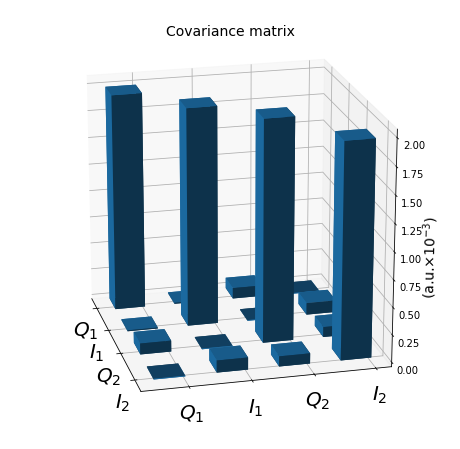

In [23]:
sigma = Cov2modes(signal,d_w,pulse_time)*1e3
### Plot the covariance matrix

# setup the figure and axes
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

# # fake data
# x = ['q', 'p']
# y = ['q', 'p']
# xx, yy = np.meshgrid(x, y)

# fake data
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


sigma_1 = np.ravel(sigma)#[sigma11, sigma21, sigma12, sigma22]
print (sigma_1)
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax1.view_init(elev=20, azim = -14)
ax1.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax1.set_title('Covariance matrix', size=14)
plt.xticks([0.2, 1.2, 2.2, 3.3], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20) 
plt.yticks([0.5, 1.5, 2.5, 3.5], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20)
ax1.set_zlabel(r'(a.u.$\times10^{-3}$)',size = 14)
#ax1.set_zlim(0, 1.0)
plt.savefig('cov2mode_dw10.png')
plt.show()

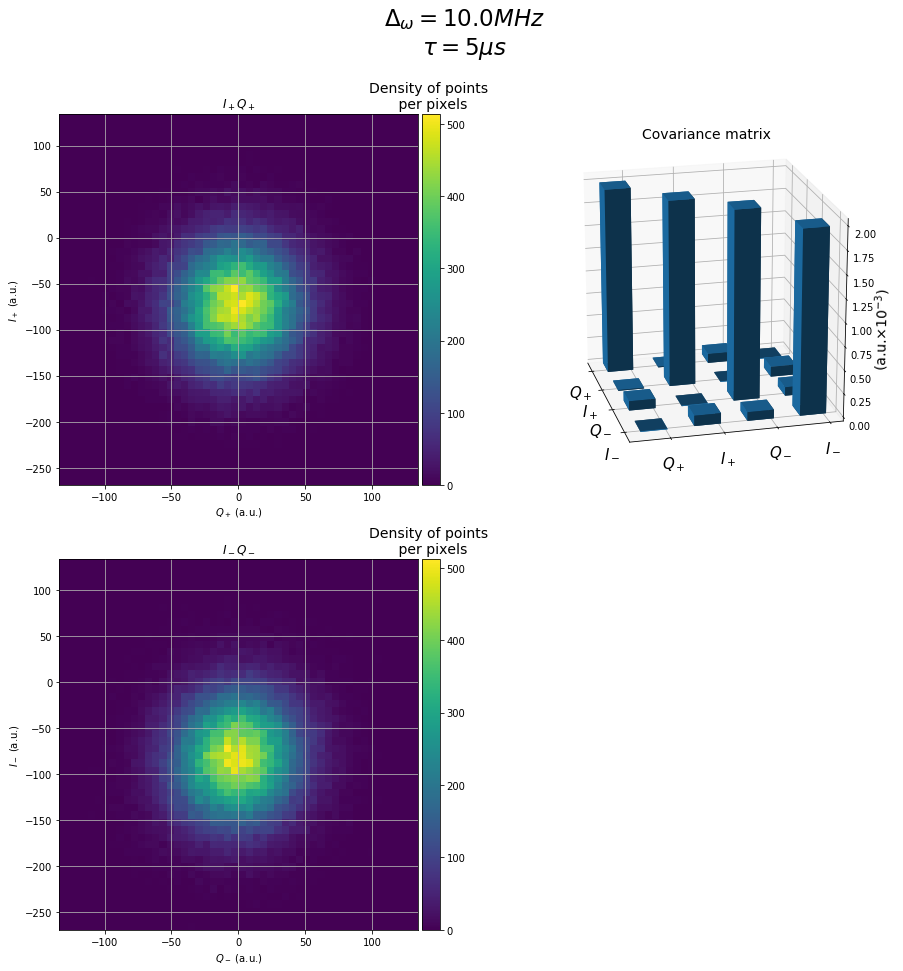

In [30]:
%matplotlib inline
extent = [(np.average(Qpa_tot)-A*np.std(Qpa_tot))*1e3, (np.average(Qpa_tot)+A*np.std(Qpa_tot))*1e3, (np.average(Ipa_tot)-6*np.std(Ipa_tot))*1e3, (np.average(Ipa_tot)+A*np.std(Ipa_tot))*1e3]
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
d_wn = d_w*1e-6
fig.suptitle(r'$\Delta_\omega=%s MHz$''\n'r'$\tau = 5\mu{}s$'%d_wn, size=23)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection = '3d')
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

ax1.title.set_text(r'$I_+Q_+$')
ax1.set_xlabel(r'$Q_+$ (a.u.)')
ax1.set_ylabel(r'$I_+$ (a.u.)')
ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower')
ax1.grid()
#fig.colorbar(ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower'))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
clb1 = fig.colorbar(ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower'), cax=cax1, orientation='vertical')
clb1.ax.set_title('Density of points \n per pixels',size=14)



ax2.title.set_text('Covariance matrix')
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
sigma_1 = np.ravel(sigma)#[sigma11, sigma21, sigma12, sigma22]
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax2.view_init(elev=20, azim = -14)
ax2.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax2.set_title('Covariance matrix', size=14)
ax2.set_xticks([0.2, 1.2, 2.2, 3.3])
ax2.set_xticklabels([r'$Q_+$', r'$I_+$', r'$Q_-$', r'$I_-$'], fontsize = 15)
ax2.set_yticks([0.5, 1.5, 2.5, 3.5],)
ax2.set_yticklabels([r'$Q_+$', r'$I_+$', r'$Q_-$', r'$I_-$'], fontsize = 15)
ax2.set_zlabel(r'(a.u.$\times10^{-3}$)',size = 14)




ax3.title.set_text(r'$I_-Q_-$')
ax3.set_xlabel(r'$Q_-$ (a.u.)')
ax3.set_ylabel(r'$I_-$ (a.u.)')
ax3.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
#ax3.colorbar(label = 'Density of points per pixels')
ax3.grid()
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
clb3 = fig.colorbar(ax3.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower'), cax=cax3, orientation='vertical')
clb3.ax.set_title('Density of points \n per pixels',size=14)

fig.savefig('ALLsimu.png')
plt.show()

In [42]:
n = 125
t_init = 0
t_final = 1e-6
T = t_final-t_init
n = int(np.ceil((T)/8e-9))#Point per pulsed length
pulse_length = n*8e-9

pulse_time = np.linspace(0,pulse_length,n)

## Evolution of the diagonal elements of the covariance matrix as a function of $\Delta_\omega$

In [43]:
N_points = 30
Ld_w = np.linspace(0,30e6,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    DATAIQ.append(IQpm(signal,Ld_w[k],pulse_time))
    DATAcov.append(Cov2modes(signal,Ld_w[k],pulse_time))

In [44]:
sig_00 = []
sig_11 = []
sig_22 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_11.append(DATAcov[k][1,1])
    sig_22.append(DATAcov[k][2,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_11 = np.asarray(sig_11)
sig_22 = np.asarray(sig_22)
sig_33 = np.asarray(sig_33) 
Ld_w = np.asarray(Ld_w)

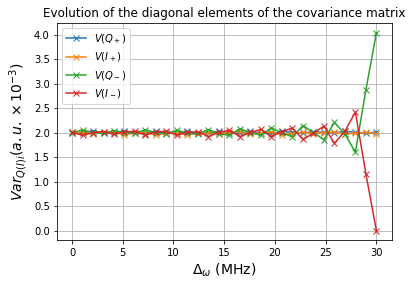

In [45]:
plt.title('Evolution of the diagonal elements of the covariance matrix')
plt.plot(Ld_w*1e-6,sig_00*1e3,marker='x',label = r'$V(Q_+)$')
plt.plot(Ld_w*1e-6,sig_11*1e3,marker='x',label = r'$V(I_+)$')
plt.plot(Ld_w*1e-6,sig_22*1e3,marker='x',label = r'$V(Q_-)$')
plt.plot(Ld_w*1e-6,sig_33*1e3,marker='x',label = r'$V(I_-)$')
plt.xlabel(r'$\Delta_\omega$ (MHz)',size = 14)
plt.ylabel(r'$Var_{Q(I)i} (a.u. \times10^{-3})$',size = 14)
#plt.ylim(0.0018,0.0021)
#plt.xlim(0,10)
plt.legend()
plt.grid()
plt.savefig('EvolSigmaDiagSimu.png',dpi=200)
plt.show()

In [46]:
N_points = 30
Ld_w = np.linspace(0,30e6,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    #DATAIQ.append(IQpm(ADC1,Ld_w[k],pulse_time))
    DATAcov.append(Cov2modes(signal,Ld_w[k],pulse_time))

In [47]:
sig_00 = []
sig_01 = []
sig_02 = []
sig_03 = []

sig_10 = []
sig_11 = []
sig_12 = []
sig_13 = []

sig_20 = []
sig_21 = []
sig_22 = []
sig_23 = []

sig_30 = []
sig_31 = []
sig_32 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_01.append(DATAcov[k][0,1])
    sig_02.append(DATAcov[k][0,2])
    sig_03.append(DATAcov[k][0,3])
    
    sig_10.append(DATAcov[k][1,0])
    sig_11.append(DATAcov[k][1,1])
    sig_12.append(DATAcov[k][1,2])
    sig_13.append(DATAcov[k][1,3])
    
    sig_20.append(DATAcov[k][2,0])
    sig_21.append(DATAcov[k][2,1])
    sig_22.append(DATAcov[k][2,2])
    sig_23.append(DATAcov[k][2,3])
    
    sig_30.append(DATAcov[k][3,0])
    sig_31.append(DATAcov[k][3,1])
    sig_32.append(DATAcov[k][3,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_01 = np.asarray(sig_01)
sig_02 = np.asarray(sig_02)
sig_03 = np.asarray(sig_03)

sig_10 = np.asarray(sig_10)
sig_11 = np.asarray(sig_11)
sig_12 = np.asarray(sig_12)
sig_13 = np.asarray(sig_13)

sig_20 = np.asarray(sig_20)
sig_21 = np.asarray(sig_21)
sig_22 = np.asarray(sig_22)
sig_23 = np.asarray(sig_23)

sig_30 = np.asarray(sig_30)
sig_31 = np.asarray(sig_31)
sig_32 = np.asarray(sig_32)
sig_33 = np.asarray(sig_33)
Ld_w = np.asarray(Ld_w)

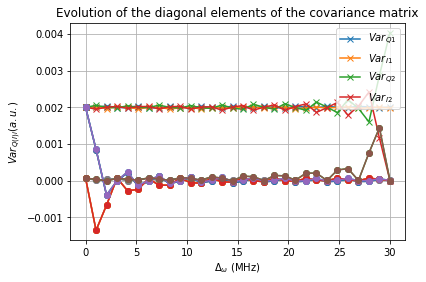

In [48]:
plt.title('Evolution of the diagonal elements of the covariance matrix')
plt.plot(Ld_w*1e-6,sig_00,marker='x',label = r'$Var_{Q1}$')
plt.plot(Ld_w*1e-6,sig_11,marker='x',label = r'$Var_{I1}$')
plt.plot(Ld_w*1e-6,sig_22,marker='x',label = r'$Var_{Q2}$')
plt.plot(Ld_w*1e-6,sig_33,marker='x',label = r'$Var_{I2}$')


plt.plot(Ld_w*1e-6,sig_01,marker='o')
plt.plot(Ld_w*1e-6,sig_02,marker='o')
plt.plot(Ld_w*1e-6,sig_03,marker='o')

plt.plot(Ld_w*1e-6,sig_10,marker='o')
plt.plot(Ld_w*1e-6,sig_12,marker='o')
plt.plot(Ld_w*1e-6,sig_13,marker='o')

plt.plot(Ld_w*1e-6,sig_20,marker='o')
plt.plot(Ld_w*1e-6,sig_21,marker='o')
plt.plot(Ld_w*1e-6,sig_23,marker='o')

plt.plot(Ld_w*1e-6,sig_30,marker='o')
plt.plot(Ld_w*1e-6,sig_31,marker='o')
plt.plot(Ld_w*1e-6,sig_32,marker='o')

plt.xlabel(r'$\Delta_\omega$ (MHz)')
plt.ylabel(r'$Var_{Q(I)i} (a.u.)$')
#plt.ylim(0.,0.08)
#plt.xlim(0,15)
plt.legend()
plt.grid()
plt.savefig('EvolSigmaSimuTotYX.png',dpi=200)
plt.show()

## Tweaking the integration time

In [55]:
t_init = 0
t_final = 1e-6
T = t_final-t_init
n = int(np.ceil((T)/8e-9))#Point per pulsed length
pulse_length = n*8e-9

pulse_time = np.linspace(0,pulse_length,n)

time = np.linspace(0,pulse_length*N_Pulse,n*N_Pulse)
T_final = time[-1]
n

125

In [56]:
t_list = np.linspace(t_init,t_final,20)
t_list = np.asarray(t_list)

In [57]:
d_w = 10e6
IQT = []
DATAcovT = []

for k in range(len(t_list)):
    nn = int(np.ceil((t_list[k])/8e-9))
    pulse_time = np.linspace(0,t_list[k],nn)
    DATAcovT.append(Cov2modes(signal,d_w,pulse_time))

In [58]:
sig_00T = []
sig_11T = []
sig_22T = []
sig_33T = []

for k in range(len(t_list)):
    sig_00T.append(DATAcovT[k][0,0])
    sig_11T.append(DATAcovT[k][1,1])
    sig_22T.append(DATAcovT[k][2,2])
    sig_33T.append(DATAcovT[k][3,3])
sig_00T = np.asarray(sig_00T)
sig_11T = np.asarray(sig_11T)
sig_22T = np.asarray(sig_22T)
sig_33T = np.asarray(sig_33T) 
t_list = np.asarray(t_list)

C:\Users\Vincent\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


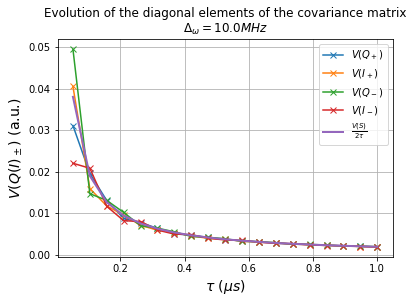

In [61]:
d_wn = d_w*1e-6
plt.title('Evolution of the diagonal elements of the covariance matrix\n'r'$\Delta_\omega = %s MHz$' %d_wn)
plt.plot(t_list*1e6,sig_00T,marker='x',label = r'$V(Q_+)$')
plt.plot(t_list*1e6,sig_11T,marker='x',label = r'$V(I_+)$')
plt.plot(t_list*1e6,sig_22T,marker='x',label = r'$V(Q_-)$')
plt.plot(t_list*1e6,sig_33T,marker='x',label = r'$V(I_-)$')
plt.plot(t_list*1e6,0.004/(2*t_list*1e6),label = r'$\frac{V(S)}{2\tau}$',linewidth = 2)
plt.xlabel(r'$\tau$ $(\mu{s})$',size=14)
plt.ylabel(r'$V(Q(I)_\pm)$ (a.u.)',size=14)
#plt.ylim(0.0018,0.0021)
#plt.xlim(0,10)
plt.legend()
plt.grid()
plt.savefig('EvolSigmaDiagSimuTime_dw10.png',dpi=200)
plt.show()

# Stop

In [ ]:
d_w = 10e6

#Cp stand for positive cosine, Sp positive sine, Cm negative cosine and Sm negative sine
Cp = np.cos((w_if+d_w)*pulse_time)
Sp = np.sin((w_if+d_w)*pulse_time)
Cm = np.cos((w_if-d_w)*pulse_time)
Sm = np.sin((w_if-d_w)*pulse_time)

In [ ]:
#ADC1 = np.random.normal(0.01, 0.0025, n*N_Pulse)

Qp = ADC1
Ip = ADC1
Qm = ADC1
Im = ADC1

In [ ]:
plt.plot(ADC1)

Let's now sequence our signals to get individual pulses

In [ ]:
#The 's' index here means, sequenced.
Qps = []
Ips = []
Qms = []
Ims = []

for k in range(N_Pulse):
    Qps.append(Qp[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Cp)
    Ips.append(Ip[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Sp)
    Qms.append(Qm[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Cm)
    Ims.append(Im[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Sm)

Now we average each pulse.

In [ ]:
#The 'a' index here means, averaged.
Qpa = []
Ipa = []
Qma = []
Ima = []
#Recheck normalization by duration time, to get proper dimensions in the end
for k in range(N_Pulse):
    Qpa.append(np.average(Qps[k]))
    Ipa.append(np.average(Ips[k]))
    Qma.append(np.average(Qms[k]))
    Ima.append(np.average(Ims[k]))
Qpa = np.asarray(Qpa)
Ipa = np.asarray(Ipa)
Qma = np.asarray(Qma)
Ima = np.asarray(Ima)

In [ ]:
plt.title('IQ plane')
plt.xlabel('Q (V)')
plt.ylabel('I (V)')
A = 5
plt.xlim(np.average(Qpa)-A*np.std(Qpa), np.average(Qpa)+A*np.std(Qpa))
plt.ylim(np.average(Ipa)-A*np.std(Ipa), np.average(Ipa)+A*np.std(Ipa))
plt.scatter(Qpa,Ipa,label=r'$+\Delta_\omega$')
plt.scatter(Qma,Ima,label=r'$-\Delta_\omega$')
plt.show()

In [ ]:
heatmap1, xedges, yedges = np.histogram2d(Qpa, Ipa, bins=50)
heatmap2, xedges, yedges = np.histogram2d(Qma, Ima, bins=50)
extent = [(np.average(Qpa)-A*np.std(Qpa))*1e3, (np.average(Qpa)+A*np.std(Qpa))*1e3, (np.average(Ipa)-6*np.std(Ipa))*1e3, (np.average(Ipa)+A*np.std(Ipa))*1e3]

plt.clf()
plt.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower')
#plt.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
plt.title('I1-Q1 plane ')
plt.xlabel('Q1 (mV)')
plt.ylabel('I1 (mV)')
plt.colorbar(label = 'Density of points per pixels')
plt.grid()
plt.savefig('mode1.png',dpi=200)
plt.show()

In [ ]:
#heatmap1, xedges, yedges = np.histogram2d(Qpa, Ipa, bins=50)
heatmap2, xedges, yedges = np.histogram2d(Qma, Ima, bins=50)
#extent = [(np.average(Qma)-A*np.std(Qma))*1e3, (np.average(Qma)+A*np.std(Qma))*1e3, (np.average(Ima)-6*np.std(Ima))*1e3, (np.average(Ima)+A*np.std(Ima))*1e3]

plt.clf()
#plt.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower')
plt.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
plt.title('I2-Q2 plane ')
plt.xlabel('Q2 (mV)')
plt.ylabel('I2 (mV)')
plt.colorbar(label = 'Density of points per pixels')
plt.grid()
plt.savefig('mode2.png',dpi=200)
plt.show()

In [ ]:
#Conversion to mV
q1 = Qpa*1e3
p1 = Ipa*1e3

q2 = Qma*1e3
p2 = Ima*1e3

q1_m = np.average(q1)
p1_m = np.average(p1)
q2_m = np.average(q2)
p2_m = np.average(p2)

R = (q1_m, p1_m, q2_m, p2_m)
R = np.array(R)

s_11 = np.average(q1**2) - (np.average(q1))**2
s_22 = np.average(p1**2) - (np.average(p1))**2
s_12 = 0.5 *np.average(q1*p1 + p1*q1) - np.average(q1)*np.average(p1)
s_21 = s_12

A = np.array([[s_11, s_12], [s_21, s_22]])

s_33 = np.average(q2**2) - (np.average(q2))**2
s_44 = np.average(p2**2) - (np.average(p2))**2
s_34 = 0.5 *np.average(q2*p2 + p2*q2) - np.average(q2)*np.average(p2)
s_43 = s_34

B = np.array([[s_33, s_34], [s_43, s_44]])
                            
                            
s_13 = 0.5 *np.average(q1*q2 + q2*q1) - np.average(q1)*np.average(q2)
s_24 = 0.5 *np.average(p1*p2 + p2*p1) - np.average(p1)*np.average(p2)
s_14 = 0.5 *np.average(q1*p2 + p2*q1) - np.average(q1)*np.average(p2)
s_23 = s_14

C = np.array([[s_13, s_14], [s_23, s_24]])
D = C.transpose()
                   

sigma = np.block([[A, C],[D, B]])

det = np.linalg.det(sigma)
#sigma_inv = np.linalg.inv(sigma)

print('cov matrix: ', sigma)
print ()
print('determinant: ', det)


print()
print('A: ', A)
print('B: ', B)
print('C: ', C)

In [ ]:
### Plot the covariance matrix

# setup the figure and axes
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

# # fake data
# x = ['q', 'p']
# y = ['q', 'p']
# xx, yy = np.meshgrid(x, y)

# fake data
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


sigma_1 = np.ravel(sigma)#[sigma11, sigma21, sigma12, sigma22]
print (sigma_1)
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax1.view_init(elev=20, azim = -14)
ax1.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax1.set_title('Covariance matrix', size=14)
plt.xticks([0.2, 1.2, 2.2, 3.3], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20) 
plt.yticks([0.5, 1.5, 2.5, 3.5], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20)
ax1.set_zlabel(r'$mV^2$')
#ax1.set_zlim(0, 1.0)
plt.savefig('cov2mode_dw0.png')
plt.show()

In [ ]:
%matplotlib inline
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
d_wn = d_w*1e-6
fig.suptitle(r'$\Delta_\omega=%s MHz$' %d_wn,size=23)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection = '3d')
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.title.set_text(r'$I_1Q_1$')
ax1.set_xlabel('Q1 (mV)')
ax1.set_ylabel('I1 (mV)')
ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower')
ax1.grid()
#fig.colorbar(ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower'))


ax2.title.set_text('Covariance matrix')
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


sigma_1 = np.ravel(sigma)#[sigma11, sigma21, sigma12, sigma22]
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax2.view_init(elev=20, azim = -14)
ax2.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax2.set_title('Covariance matrix', size=14)
ax2.set_xticks([0.2, 1.2, 2.2, 3.3])
ax2.set_xticklabels([r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], fontsize = 15)
ax2.set_yticks([0.5, 1.5, 2.5, 3.5],)
ax2.set_yticklabels([r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], fontsize = 15)
ax2.set_zlabel(r'$mV^2$')

ax3.title.set_text(r'$I_2Q_2$')
ax3.set_xlabel('Q2 (mV)')
ax3.set_ylabel('I2 (mV)')
ax3.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
#ax3.colorbar(label = 'Density of points per pixels')
ax3.grid()


ax4.title.set_text('Frequencies')
ax4.set_xlabel('Frequency (MHz)')
#ax3.set_ylabel('I2 (mV)')
a = 1e-6
ax4.scatter(w_p*a,0,label=r'$\omega_p$')
ax4.scatter([(w_p-w_if)*a,(w_p+w_if)*a],[0,0],label=r'$\omega_p\pm\omega_{IF}$')
ax4.scatter((w_p-d_w)*a,0,label='Signal')
ax4.scatter((w_p+d_w)*a,0,label='Idler')
ax4.set_yticks([0])
ax4.grid()
ax4.legend()
fig.savefig('test.png')
plt.show()

In [ ]:

plt.scatter(w_p,0)
plt.scatter([w_p-w_if,w_p+w_if],[0,0],label=r'$\omega_p\pm\omega_{IF}$')
plt.scatter(w_p-d_w,0,label='Signal')
plt.scatter(w_p+d_w,0,label='Idler')
plt.yticks([0])
plt.grid()
plt.legend()
plt.show()

## Function formulation

Let's now formalzed all the above in a function formalism

In [ ]:
def IQpm(signal,d_w):
    #Cp stand for positive cosine, Sp positive sine, Cm negative cosine and Sm negative sine
    Cp = np.cos((w_if+d_w)*pulse_time)
    Sp = np.sin((w_if+d_w)*pulse_time)
    Cm = np.cos((w_if-d_w)*pulse_time)
    Sm = np.sin((w_if-d_w)*pulse_time)
    Qp = signal
    Ip = signal
    Qm = signal
    Im = signal
    #The 's' index here means, sequenced.
    Qps = []
    Ips = []
    Qms = []
    Ims = []

    for k in range(N_Pulse):
        Qps.append(Qp[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Cp)
        Ips.append(Ip[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Sp)
        Qms.append(Qm[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Cm)
        Ims.append(Im[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Sm)
        #The 'a' index here means, averaged.
    Qpa = []
    Ipa = []
    Qma = []
    Ima = []

    for k in range(N_Pulse):
        Qpa.append(np.average(Qps[k]))
        Ipa.append(np.average(Ips[k]))
        Qma.append(np.average(Qms[k]))
        Ima.append(np.average(Ims[k]))
    Qpa = np.asarray(Qpa)
    Ipa = np.asarray(Ipa)
    Qma = np.asarray(Qma)
    Ima = np.asarray(Ima)
    return Qpa, Ipa, Qma, Ima

In [ ]:
def Cov2modes(signal,d_w):
    #Conversion to mV
    q1 = IQpm(signal,d_w)[0]*1e3
    p1 = IQpm(signal,d_w)[1]*1e3

    q2 = IQpm(signal,d_w)[2]*1e3
    p2 = IQpm(signal,d_w)[3]*1e3

    q1_m = np.average(q1)
    p1_m = np.average(p1)
    q2_m = np.average(q2)
    p2_m = np.average(p2)

    R = (q1_m, p1_m, q2_m, p2_m)
    R = np.array(R)

    s_11 = np.average(q1**2) - (np.average(q1))**2
    s_22 = np.average(p1**2) - (np.average(p1))**2
    s_12 = 0.5 *np.average(q1*p1 + p1*q1) - np.average(q1)*np.average(p1)
    s_21 = s_12

    A = np.array([[s_11, s_12], [s_21, s_22]])

    s_33 = np.average(q2**2) - (np.average(q2))**2
    s_44 = np.average(p2**2) - (np.average(p2))**2
    s_34 = 0.5 *np.average(q2*p2 + p2*q2) - np.average(q2)*np.average(p2)
    s_43 = s_34

    B = np.array([[s_33, s_34], [s_43, s_44]])
                            
                            
    s_13 = 0.5 *np.average(q1*q2 + q2*q1) - np.average(q1)*np.average(q2)
    s_24 = 0.5 *np.average(p1*p2 + p2*p1) - np.average(p1)*np.average(p2)
    s_14 = 0.5 *np.average(q1*p2 + p2*q1) - np.average(q1)*np.average(p2)
    s_23 = s_14

    C = np.array([[s_13, s_14], [s_23, s_24]])
    D = C.transpose()
                   

    sigma = np.block([[A, C],[D, B]])

    det = np.linalg.det(sigma)
    #sigma_inv = np.linalg.inv(sigma)
    return sigma#, det, sigma_inv

Set of functions to plot the graph in an elegant way

In [ ]:
def IQmap(fig, Q, I, bins):
    heatmap, xedges, yedges = np.histogram2d(Q, I, bins=bins)
    extent = [(np.average(Qpa)-A*np.std(Qpa))*1e3, (np.average(Qpa)+A*np.std(Qpa))*1e3, (np.average(Ipa)-6*np.std(Ipa))*1e3, (np.average(Ipa)+A*np.std(Ipa))*1e3]
    ax1 = fig.add_subplot(221)
    ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower')
    #plt.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
    ax1.title.set_text(r'$I_1Q_1$')
    ax1.set_xlabel('Q1 (mV)')
    ax1.set_ylabel('I1 (mV)')
    ax1.colorbar(label = 'Density of points per pixels')
    ax1.grid()
    #plt.savefig('mode1.png',dpi=200)
    


Let's now analyze the dependency upon $\Delta_\omega$

In [ ]:
N_points = 30
Ld_w = np.linspace(0,30e6,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    DATAIQ.append(IQpm(ADC1,Ld_w[k]))
    DATAcov.append(Cov2modes(ADC1,Ld_w[k]))

In [ ]:
sig_00 = []
sig_11 = []
sig_22 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_11.append(DATAcov[k][1,1])
    sig_22.append(DATAcov[k][2,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_11 = np.asarray(sig_11)
sig_22 = np.asarray(sig_22)
sig_33 = np.asarray(sig_33) 
Ld_w = np.asarray(Ld_w)


In [ ]:
plt.title('Evolution of the diagonal elements of the covariance matrix')
plt.plot(Ld_w*1e-6,sig_00,marker='x',label = r'$\sigma_{Q1}$')
plt.plot(Ld_w*1e-6,sig_11,marker='x',label = r'$\sigma_{I1}$')
plt.plot(Ld_w*1e-6,sig_22,marker='x',label = r'$\sigma_{Q2}$')
plt.plot(Ld_w*1e-6,sig_33,marker='x',label = r'$\sigma_{I2}$')
plt.xlabel(r'$\Delta_\omega$ (MHz)')
plt.ylabel(r'$\sigma_{Q(I)i} (mV^2)$')
plt.ylim(0.006,0.09)
plt.xlim(0,10)
plt.legend()
plt.savefig('EvolSigmaDiagSimu.png',dpi=200)
plt.show()

In [ ]:
### Plot the covariance matrix

# setup the figure and axes
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

# # fake data
# x = ['q', 'p']
# y = ['q', 'p']
# xx, yy = np.meshgrid(x, y)

# fake data
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


sigma_1 = np.ravel(DATAcov[4])#[sigma11, sigma21, sigma12, sigma22]
print (sigma_1)
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax1.view_init(elev=20, azim = -14)
ax1.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax1.set_title('Covariance matrix', size=14)
plt.xticks([0.2, 1.2, 2.2, 3.3], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20) 
plt.yticks([0.5, 1.5, 2.5, 3.5], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20)
ax1.set_zlabel(r'$mV^2$')
#ax1.set_zlim(0, 1.0)
plt.savefig('cov2mode.png')
plt.show()

## Test simulated signal

In [ ]:
signal = np.random.normal(0.01, 0.0025, n*N_Pulse)

In [ ]:
N_points = 100
Ld_w = np.linspace(0,w_if,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    DATAIQ.append(IQpm(signal,Ld_w[k]))
    DATAcov.append(Cov2modes(signal,Ld_w[k]))

In [ ]:
sig_00 = []
sig_11 = []
sig_22 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_11.append(DATAcov[k][1,1])
    sig_22.append(DATAcov[k][2,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_11 = np.asarray(sig_11)
sig_22 = np.asarray(sig_22)
sig_33 = np.asarray(sig_33) 
Ld_w = np.asarray(Ld_w)

In [ ]:
sig_00

In [ ]:
plt.title('Evolution of the diagonal elements of the covariance matrix')
plt.plot(Ld_w*1e-6,sig_00,marker='x',label = r'$\sigma_{Q1}$')
plt.plot(Ld_w*1e-6,sig_11,marker='x',label = r'$\sigma_{I1}$')
plt.plot(Ld_w*1e-6,sig_22,marker='x',label = r'$\sigma_{Q2}$')
plt.plot(Ld_w*1e-6,sig_33,marker='x',label = r'$\sigma_{I2}$')
plt.xlabel(r'$\Delta_\omega$ (MHz)')
plt.ylabel(r'$\sigma_{Q(I)i} (mV^2)$')
plt.ylim(0.02,0.06)
#plt.xlim(10,20)
plt.legend()
plt.grid()
plt.savefig('EvolSigmaDiagMagSimul3.png',dpi=200)
plt.show()

In [ ]:
x = np.linspace(0,t_final*N_Pulse,n*N_Pulse)
plt.plot(x,signal)
plt.xlabel('Time (s)')
plt.ylabel('Noise intensity (a.u.)')